[Table of Contents](./table_of_contents.ipynb)

# Adaptive Filtering

In [3]:
#format the book
%matplotlib inline
from __future__ import division, print_function
from book_format import load_style
load_style()

## Introduction

So far we have considered the problem of tracking objects that are well behaved in relation to our process model. For example, we can use a constant velocity filter to track an object moving in a straight line. So long as the object moves in a straight line at a reasonably constant speed, or varies its track and/or velocity very slowly this filter will perform very well. Suppose instead that we are trying to track a maneuvering target, such as a car along a road, an aircraft in flight, and so on. In these situations the filters perform quite poorly. Alternatively, consider a situation such as tracking a sailboat in the ocean. Even if we model the control inputs we have no way to model the wind or the ocean currents. 

A first order approach to this problem is to make the process noise $\mathbf{Q}$ larger to account for the unpredictability of the system dynamics. While this can work in the sense of providing a non-diverging filter, the result is typically far from optimal. The larger $\mathbf{Q}$ results in the filter giving more emphasis to the noise in the measurements. We will see an example of this shortly.

In this chapter we will discuss the concept of an *adaptive filter*. The filter will *adapt* itself when it detects dynamics that the process model cannot account for. I will start with an example of the problem, and then discuss and implement various adaptive filters.

## Maneuvering Targets

We need a simulation of a maneuvering target.  I will implement a simple 2D model with steering inputs. You provide a new speed and/or direction, and it will modify its state to match.

In [5]:
from math import sin, cos, radians

def angle_between(x, y):
  return min(y-x, y-x+360, y-x-360, key=abs)

class ManeuveringTarget(object): 
    def __init__(self, x0, y0, v0, heading):
        self.x = x0
        self.y = y0
        self.vel = v0
        self.hdg = heading
        
        self.cmd_vel = v0
        self.cmd_hdg = heading
        self.vel_step = 0
        self.hdg_step = 0
        self.vel_delta = 0
        self.hdg_delta = 0
        
        
    def update(self):
        vx = self.vel * cos(radians(90-self.hdg))
        vy = self.vel * sin(radians(90-self.hdg))
        self.x += vx
        self.y += vy
        
        if self.hdg_step > 0:
            self.hdg_step -= 1
            self.hdg += self.hdg_delta

        if self.vel_step > 0:
            self.vel_step -= 1
            self.vel += self.vel_delta
        return (self.x, self.y)
        

    def set_commanded_heading(self, hdg_degrees, steps):
        self.cmd_hdg = hdg_degrees
        self.hdg_delta = angle_between(self.cmd_hdg, 
                                       self.hdg) / steps
        if abs(self.hdg_delta) > 0:
            self.hdg_step = steps
        else:
            self.hdg_step = 0
            
            
    def set_commanded_speed(self, speed, steps):
        self.cmd_vel = speed
        self.vel_delta = (self.cmd_vel - self.vel) / steps
        if abs(self.vel_delta) > 0:
            self.vel_step = steps
        else:
            self.vel_step = 0    

Now let's implement a simulated sensor with noise.

In [6]:
from numpy.random import randn

class NoisySensor(object):
    def __init__(self, std_noise=1.):
        self.std = std_noise

    def sense(self, pos):
        """Pass in actual position as tuple (x, y).       
        Returns position with noise added (x,y)"""
        
        return (pos[0] + (randn() * self.std), 
                pos[1] + (randn() * self.std))

Now let's generate a track and plot it to test that everything is working. I'll put the data generation in a function so we can create paths of different lengths (why will be clear soon).

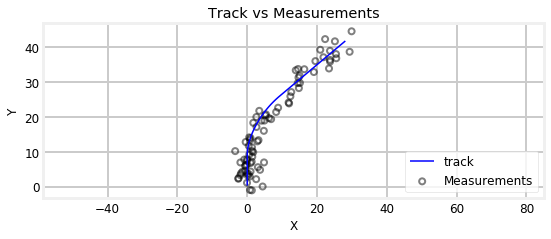

In [7]:
import kf_book.book_plots as bp
import numpy as np
import matplotlib.pyplot as plt

def generate_data(steady_count, std):
    t = ManeuveringTarget(x0=0, y0=0, v0=0.3, heading=0)
    xs, ys = [], []

    for i in range(30):
        x, y = t.update()
        xs.append(x)
        ys.append(y)

    t.set_commanded_heading(310, 25)
    t.set_commanded_speed(1, 15)

    for i in range(steady_count):
        x, y = t.update()
        xs.append(x)
        ys.append(y)

    ns = NoisySensor(std)
    pos = np.array(list(zip(xs, ys)))
    zs = np.array([ns.sense(p) for p in pos])
    return pos, zs

sensor_std = 2.
track, zs = generate_data(50, sensor_std)
plt.figure()
bp.plot_measurements(*zip(*zs), alpha=0.5)
plt.plot(*zip(*track), color='b', label='track')
plt.axis('equal')
plt.legend(loc=4)
bp.set_labels(title='Track vs Measurements', x='X', y='Y')

This large amount of noise allows us to see the effect of various design choices more easily.

Now we can implement a Kalman filter to track this object. But let's make a simplification. The *x* and *y* coordinates are independent, so we can track each independently. In the remainder of this chapter we will only track the *x* coordinate to keep the code and matrices as small as possible. 

We start with a constant velocity filter.

In [8]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

def make_cv_filter(dt, std):
    cvfilter = KalmanFilter(dim_x = 2, dim_z=1)
    cvfilter.x = np.array([0., 0.])
    cvfilter.P *= 3
    cvfilter.R *= std**2
    cvfilter.F = np.array([[1, dt],
                           [0,  1]], dtype=float)
    cvfilter.H = np.array([[1, 0]], dtype=float)
    cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=0.02)
    return cvfilter

def initialize_filter(kf, std_R=None):
    """ helper function - we will be reinitialing the filter
    many times.
    """
    kf.x.fill(0.)
    kf.P = np.eye(kf.dim_x) * .1
    if std_R is not None:
        kf.R = np.eye(kf.dim_z) * std_R

Now we run it:

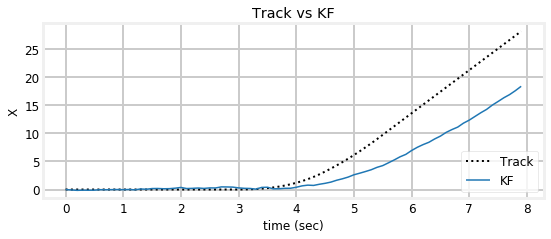

In [9]:
sensor_std = 2.
dt = 0.1

# initialize filter
cvfilter = make_cv_filter(dt, sensor_std)
initialize_filter(cvfilter)

track, zs = generate_data(50, sensor_std)

# run it
z_xs = zs[:, 0]
kxs, _, _, _ = cvfilter.batch_filter(z_xs)

# plot results
bp.plot_track(track[:, 0], dt=dt)
bp.plot_filter(kxs[:, 0], dt=dt, label='KF')
bp.set_labels(title='Track vs KF', x='time (sec)', y='X');
plt.legend(loc=4);

We can see from the plot that the Kalman filter was unable to track the change in heading. Recall from the **g-h Filter** chapter that this is because the filter is not modeling acceleration, hence it will always lag the input. The filter will eventually catch up with the signal if the signal enters a steady state. Let's look at that.

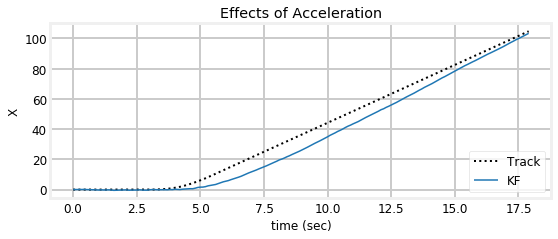

In [10]:
# reinitialize filter
dt = 0.1
initialize_filter(cvfilter)

track2, zs2 = generate_data(150, sensor_std)
xs2 = track2[:, 0]
z_xs2 = zs2[:, 0]

kxs2, _, _, _ = cvfilter.batch_filter(z_xs2)

bp.plot_track(xs2, dt=dt)
bp.plot_filter(kxs2[:, 0], dt=dt, label='KF')
plt.legend(loc=4)
bp.set_labels(title='Effects of Acceleration', 
              x='time (sec)', y='X')

The underlying problem is that our process model is correct for the steady state sections, but incorrect for when the object is maneuvering. We can try to account for this by increasing the size of Q, like so.

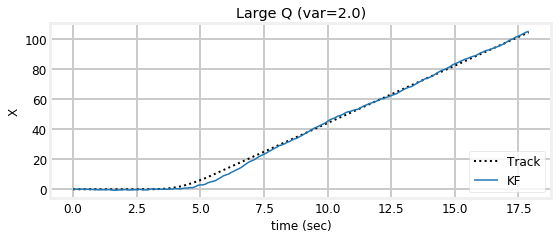

In [11]:
# reinitialize filter
dt = 0.1
initialize_filter(cvfilter)
cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=2.0)
track, zs = generate_data(50, sensor_std)

# recompute track
kxs2, _, _, _ = cvfilter.batch_filter(z_xs2)
bp.plot_track(xs2, dt=dt)
bp.plot_filter(kxs2[:, 0], dt=dt, label='KF')
plt.legend(loc=4)
bp.set_labels(title='Large Q (var=2.0)', x='time (sec)', y='X')

We can see that the filter reacquired the track more quickly, but at the cost of a lot of noise in the output. Furthermore, many tracking situations could not tolerate the amount of lag shown between seconds 4 and 8. We could reduce it further at the cost of very noisy output, like so:

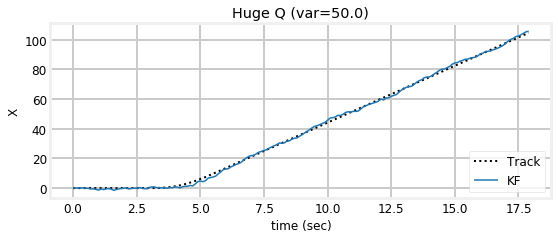

In [12]:
# reinitialize filter
dt = 0.1
initialize_filter(cvfilter)
cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=50.0)
track, zs = generate_data(50, sensor_std)

# recompute track
cvfilter.x.fill(0.)
kxs2, _, _, _ = cvfilter.batch_filter(z_xs2)

bp.plot_track(xs2, dt=dt)
bp.plot_filter(kxs2[:, 0], dt=dt, label='KF')
plt.legend(loc=4)
bp.set_labels(title='Huge Q (var=50.0)', x='time (sec)', y='X')

Maneuvers imply acceleration, so let's implement a constant acceleration Kalman filter and see how it fairs with the same data.

In [13]:
def make_ca_filter(dt, std):
    cafilter = KalmanFilter(dim_x=3, dim_z=1)
    cafilter.x = np.array([0., 0., 0.])
    cafilter.P *= 3
    cafilter.R *= std
    cafilter.Q = Q_discrete_white_noise(dim=3, dt=dt, var=0.02)
    cafilter.F = np.array([[1, dt, 0.5*dt*dt],
                           [0, 1,         dt], 
                           [0, 0,          1]])
    cafilter.H = np.array([[1., 0, 0]])
    return cafilter

def initialize_const_accel(f):
    f.x = np.array([0., 0., 0.])
    f.P = np.eye(3) * 3

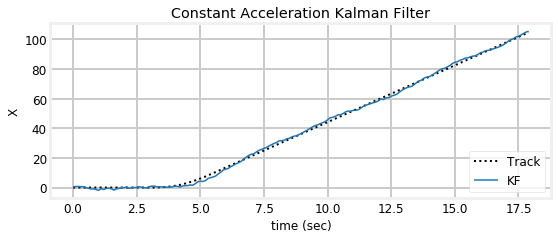

In [14]:
dt = 0.1
cafilter = make_ca_filter(dt, sensor_std)
initialize_const_accel(cafilter)

kxs2, _, _, _ = cafilter.batch_filter(z_xs2)

bp.plot_track(xs2, dt=dt)
bp.plot_filter(kxs2[:, 0], dt=dt, label='KF')
plt.legend(loc=4)
bp.set_labels(title='Constant Acceleration Kalman Filter',
              x='time (sec)', y='X')

The constant acceleration model is able to track the maneuver with no lag, but at the cost of very noisy output during the steady state behavior. The noisy output is due to the filter being unable to distinguish between the beginning of an  maneuver and noise in the signal. Noise in the signal implies an acceleration, and so the acceleration term of the filter tracks it. 

It seems we cannot win. A constant velocity filter cannot react quickly when the target is accelerating, but a constant acceleration filter misinterprets noise during zero acceleration regimes as acceleration instead of nosie.

Yet there is an important insight here that will lead us to a solution. When the target is not maneuvering (the acceleration is zero) the constant velocity filter performs optimally. When the target is maneuvering the constant acceleration filter performs well, as does the constant velocity filter with an artificially large process noise $\mathbf{Q}$. If we make a filter that adapts itself to the behavior of the tracked object we could have the best of both worlds.

## Detecting a Maneuver

Before we discuss how to create an adaptive filter we have to ask "how do we detect a maneuver?" We cannot reasonably adapt a filter to respond to maneuvers if we do not know when a maneuver is happening.

We have been defining *maneuver* as the time when the tracked object is accelerating, but in general we can say that the object is maneuvering with respect to the Kalman filter if its behavior is different than the process model being used by the filter. 

What is the mathematical consequence of a maneuvering object for the filter? The object will be behaving differently than predicted by the filter, so the residual will be large. Recall that the residual is the difference between the current prediction of the filter and the measurement. 
<img src="./figs/residual_chart.png">

To confirm this, let's plot the residual for the filter during the maneuver. I will reduce the amount of noise in the data to make it easier to see the residual.

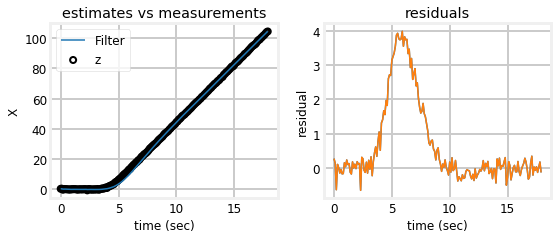

In [15]:
from kf_book.adaptive_internal import plot_track_and_residuals

def show_residual_chart():
    dt = 0.1
    sensor_std = 0.2
    
    # initialize filter
    cvfilter = make_cv_filter(dt, sensor_std)
    initialize_filter(cvfilter)
    pos2, zs2 = generate_data(150, sensor_std)
    xs2 = pos2[:, 0]
    z_xs2 = zs2[:, 0]

    cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=0.02)
    xs, res = [], []
    for z in z_xs2:
        cvfilter.predict()
        cvfilter.update([z])
        xs.append(cvfilter.x[0])
        res.append(cvfilter.y[0])
        
    xs = np.asarray(xs)
    plot_track_and_residuals(dt, xs, z_xs2, res)

show_residual_chart();

On the left I have plotted the noisy measurements against the Kalman filter output. On the right I display the residuals computed by the filter - the difference between the measurement and the predictions made by the Kalman filter. Let me emphasize this to make this clear. The plot on the right is not merely the difference between the two lines in the left plot. The left plot shows the difference between the measurements and the final Kalman filter output, whereas the right plot shows us the difference between the measurements and the *predictions of the process model*. 

That may seem like a subtle distinction, but from the plots you see it is not. The amount of deviation in the left plot when the maneuver starts is small, but the deviation in the right plot tells a different story. If the tracked object was moving according to the process model the residual plot should bounce around 0.0. This is because the measurements will be obeying the equation 

$$\mathtt{measurement} = \mathtt{process\_model}(t) + \mathtt{noise}(t)$$

Once the target starts maneuvering the predictions of the target behavior will not match the behavior as the equation will be 

$$\mathtt{measurement} = \mathtt{process\_model}(t) + \mathtt{maneuver\_delta}(t) + \mathtt{noise}(t)$$

Therefore if the residuals diverge from a mean of 0.0 we know that a maneuver has commenced.

We can see from the residual plot that we have our work cut out for us. We can clearly see the result of the maneuver in the residual plot, but the amount of noise in the signal obscures the start of the maneuver. This is our age old problem of extracting the signal from the noise. 

## Adjustable Process Noise

The first approach we will consider will use a lower order model and adjust the process noise based on whether a maneuver is occurring or not. When the residual gets "large" (for some reasonable definition of large) we will increase the process noise. This will cause the filter to favor the measurement over the process prediction and the filter will track the signal closely. When the residual is small we will then scale back the process noise.

There are many ways of doing this in the literature, I will consider a couple of choices.

### Continuous Adjustment

The first method (from Bar-Shalom [1]) normalizes the square of the residual using the following equation:

$$ \epsilon = \mathbf{y^\mathsf{T}S}^{-1}\mathbf{y}$$

where $\mathbf{y}$ is the residual and $\mathbf{S}$ is the measurement covariance, which has the equation

$$\mathbf{S} = \mathbf{HPH^\mathsf{T}} + \mathbf{R}$$

If the linear algebra used to compute this confuses you, recall that we can think of matrix inverses in terms of division, so $\epsilon = \mathbf{y^\mathsf{T}S}^{-1}\mathbf{y}$ can be thought of as computing

$$\epsilon\approx\frac{\mathbf{y}^2}{\mathbf{S}}$$

Both $\mathbf{y}$ and $\mathbf{S}$ are attributes of `filterpy.KalmanFilter` so implementation will be straightforward.

Let's look at a plot of $\epsilon$ against time.

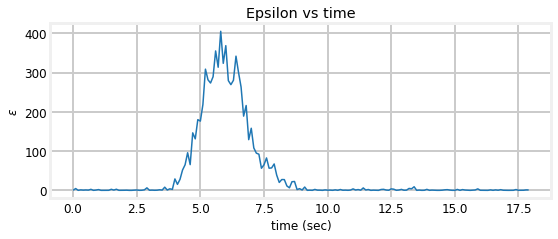

In [16]:
from numpy.linalg import inv
dt = 0.1
sensor_std = 0.2
cvfilter= make_cv_filter(dt, sensor_std)
_, zs2 = generate_data(150, sensor_std)

epss = []
for z in zs2[:, 0]:
    cvfilter.predict()
    cvfilter.update([z])
    y, S = cvfilter.y, cvfilter.S
    eps = np.dot(y.T, inv(S)).dot(y)
    epss.append(eps)

t = np.arange(0, len(epss) * dt, dt)
plt.plot(t, epss)
bp.set_labels(title='Epsilon vs time', 
              x='time (sec)', y='$\epsilon$')

This plot should make clear the effect of normalizing the residual. Squaring the residual ensures that the signal is always greater than zero, and normalizing by the measurement covariance scales the signal so that we can distinguish when the residual is markedly changed relative to the measurement noise. The maneuver starts at t=3 seconds, and we can see that $\epsilon$ starts to increase rapidly not long after that. 

We will want to start scaling $\mathbf{Q}$ up once $\epsilon$ exceeds some limit, and back down once it again falls below that limit. We multiply $\mathbf{Q}$ by a scaling factor. Perhaps there is literature on choosing this factor analytically; I derive it experimentally. We can be somewhat more analytical about choosing the limit for $\epsilon$ (named $\epsilon_{max}$) - generally speaking once the residual is greater than 3 standard deviations or so we can assume the difference is due to a real change and not to noise. However, sensors are rarely truly Gaussian and so a larger number, such as 5-6 standard deviations is used in practice.

I have implemented this algorithm using reasonable values for $\epsilon_{max}$ and the $\mathbf{Q}$ scaling factor. To make inspection of the result easier I have limited the plot to the first 10 seconds of simulation. 

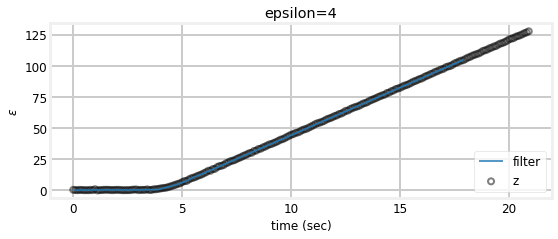

In [17]:
# reinitialize filter
dt = 0.1
sensor_std = 0.2
cvfilter = make_cv_filter(dt, sensor_std)
_, zs2 = generate_data(180, sensor_std)

Q_scale_factor = 1000.
eps_max = 4.

xs, epss = [], []

count = 0
for i, z in zip(t, zs2[:, 0]):
    cvfilter.predict()
    cvfilter.update([z])
    y, S = cvfilter.y, cvfilter.S
    eps = np.dot(y.T, inv(S)).dot(y)
    epss.append(eps)
    xs.append(cvfilter.x[0])

    if eps > eps_max:
        cvfilter.Q *= Q_scale_factor
        count += 1
    elif count > 0:
        cvfilter.Q /= Q_scale_factor
        count -= 1

bp.plot_measurements(zs2[:,0], dt=dt, label='z', alpha=0.5)
bp.plot_filter(t, xs, label='filter')
plt.legend(loc=4)
bp.set_labels(title='epsilon=4', x='time (sec)', y='$\epsilon$')

The performance of this filter is markedly better than the constant velocity filter. The constant velocity filter took roughly 10 seconds to reacquire the signal after the start of the maneuver. The adaptive filter takes under a second to do the same. 

### Continuous Adjustment - Standard Deviation Version

Another, very similar method from Zarchan [2] sets the limit based on the standard deviation of the measurement error covariance. Here the equations are:

$$ \begin{aligned}
std &= \sqrt{\mathbf{HPH}^\mathsf{T} + \mathbf{R}} \\
&= \sqrt{\mathbf{S}}
\end{aligned}
$$

If the absolute value of the residual is more than some multiple of the standard deviation computed above we increase the process noise by a fixed amount, recompute Q, and continue.

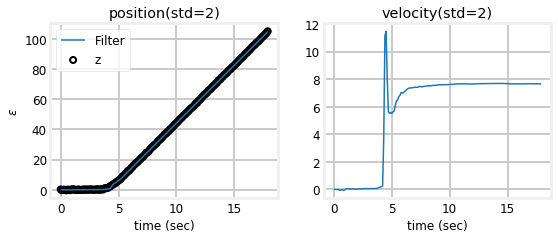

In [18]:
from math import sqrt

def zarchan_adaptive_filter(Q_scale_factor, std_scale, 
                            std_title=False,
                            Q_title=False):
    cvfilter = make_cv_filter(dt, std=0.2)
    pos2, zs2 = generate_data(180-30, std=0.2)
    xs2 = pos2[:,0]
    z_xs2 = zs2[:,0]

    # reinitialize filter
    initialize_filter(cvfilter)
    cvfilter.R = np.eye(1)*0.2

    phi = 0.02
    cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=phi)
    xs, ys = [], []
    count = 0
    for z in z_xs2:
        cvfilter.predict()
        cvfilter.update([z])
        y = cvfilter.y
        S = cvfilter.S
        std = sqrt(S)

        xs.append(cvfilter.x)
        ys.append(y)

        if abs(y[0]) > std_scale*std:
            phi += Q_scale_factor
            cvfilter.Q = Q_discrete_white_noise(2, dt, phi)
            count += 1
        elif count > 0:
            phi -= Q_scale_factor
            cvfilter.Q = Q_discrete_white_noise(2, dt, phi)
            count -= 1

    xs = np.asarray(xs)
    plt.subplot(121)
    bp.plot_measurements(z_xs2, dt=dt, label='z')
    bp.plot_filter(xs[:, 0], dt=dt, lw=1.5)
    bp.set_labels(x='time (sec)', y='$\epsilon$')
    plt.legend(loc=2)
    if std_title:
        plt.title('position(std={})'.format(std_scale))
    elif Q_title:
        plt.title('position(Q scale={})'.format(Q_scale_factor))
    else:
        plt.title('position')
        
    plt.subplot(122)
    plt.plot(np.arange(0, len(xs)*dt, dt), xs[:, 1], lw=1.5)
    plt.xlabel('time (sec)')
    if std_title:
        plt.title('velocity(std={})'.format(std_scale))
    elif Q_title:
        plt.title('velocity(Q scale={})'.format(Q_scale_factor))
    else:
        plt.title('velocity')        
    plt.show()
 
zarchan_adaptive_filter(1000, 2, std_title=True)

So I chose to use 1000 as the scaling factor for the noise, and 2 as the standard deviation limit. Why these numbers? Well, first, let's look at the difference between 2 and 3 standard deviations. 

**Two Standard Deviations**

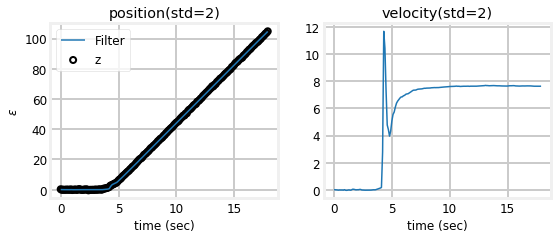

In [19]:
zarchan_adaptive_filter(1000, 2, std_title=True)

**Three Standard Deviations**

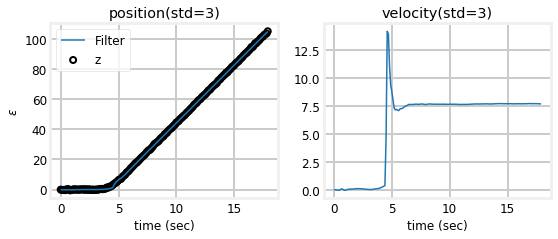

In [20]:
zarchan_adaptive_filter(1000, 3, std_title=True)

We can see from the charts that the filter output for the position is very similar regardless of weather we use 2 standard deviations or three. But the computation of the velocity is a different matter. Let's explore this further. First, let's make the standard deviation very small.

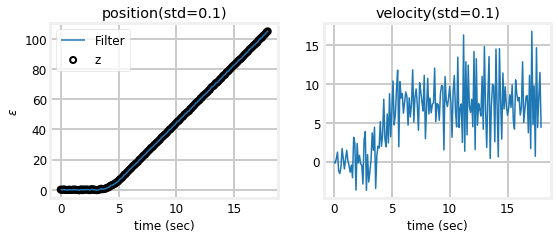

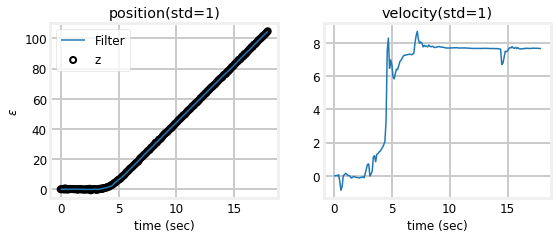

In [21]:
zarchan_adaptive_filter(1000, .1, std_title=True)
zarchan_adaptive_filter(1000, 1, std_title=True)

As the standard deviation limit gets smaller the computation of the velocity gets worse. Think about why this is so. If we start varying the filter so that it prefers the measurement over the prediction as soon as the residual deviates even slightly from the prediction we very quickly be giving almost all the weight towards the measurement. With no weight for the prediction we have no information from which to create the hidden variables. So, when the limit is 0.1 std you can see that the velocity is swamped by the noise in the measurement. On the other hand, because we are favoring the measurements so much the position follows the maneuver almost perfectly.

Now let's look at the effect of various increments for the process noise. Here I have held the standard deviation limit to 2 std, and varied the increment from 1 to 10,000.

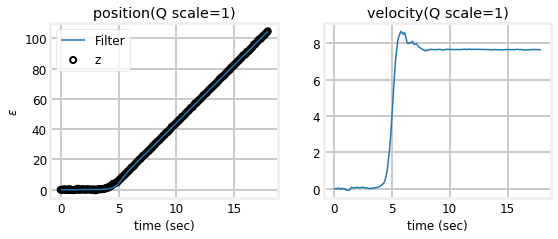

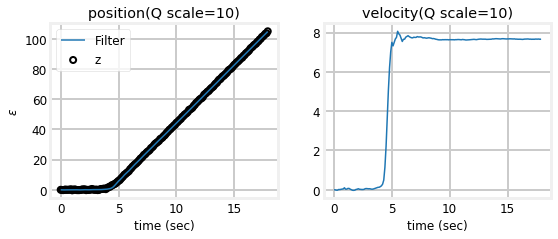

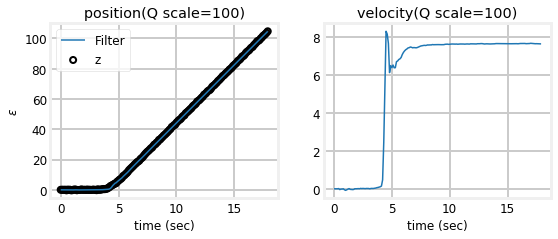

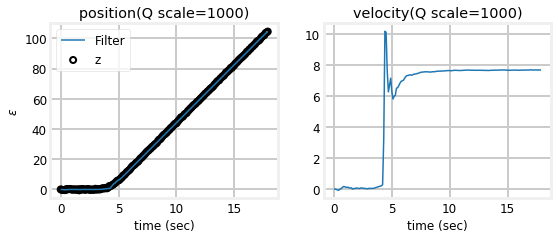

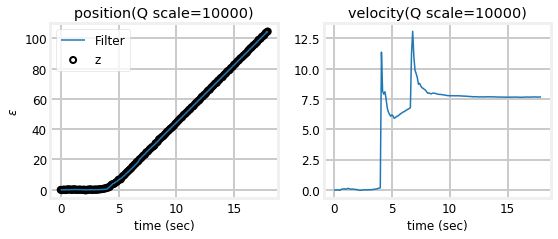

In [22]:
zarchan_adaptive_filter(1, 2, Q_title=True)
zarchan_adaptive_filter(10, 2, Q_title=True)
zarchan_adaptive_filter(100, 2, Q_title=True)
zarchan_adaptive_filter(1000, 2, Q_title=True)
zarchan_adaptive_filter(10000, 2, Q_title=True)

Here we can see that the position estimate gets marginally better as the increment factor increases, but that the velocity estimate starts to create a large overshoot. 

It isn't possible for me to tell you which of these is 'correct'. You will need to test your filter's performance against real and simulated data, and choose the design that best matches the performance you need for each of the state variables.

## Fading Memory Filter

Fading memory filters are not normally classified as an adaptive filter since they do not adapt to the the input, but they do provide good performance with maneuvering targets. They also have the benefit of having a very simple computational form for first, second, and third order kinematic filters (e.g. the filters we are using in this chapter). This simple form does not require the Ricatti equations to compute the gain of the Kalman filter, which drastically reduces the amount of computation. However, there is also a form that works with the standard Kalman filter. I will focus on the latter in this chapter since our focus is more on adaptive filters. Both forms of the fading memory filter are implemented in `FilterPy`.

The Kalman filter is recursive, but it incorporates all of the previous measurements into the current computation of the filter gain. If the target behavior is consistent with the process model than this allows the Kalman filter to find the optimal estimate for every measurement. Consider a ball in flight - we can clearly estimate the position of the ball at time t better if we take into account all the previous measurement. If we only used some of the measurements we would be less certain about the current position, and thus more influenced by the noise in the measurement. If this is still not clear, consider the worst case. Suppose we forget all but the last measurement and estimates. We would then have no confidence in the position and trajectory of the ball, and would have little choice but to weight the current measurement heavily. If the measurement is noisy, the estimate is noisy. We see this effect every time a Kalman filter is initialized. The early estimates are noisy, but then they settle down as more measurements are acquired.

However, if the target is maneuvering it is not always behaving like the process model predicts. In this case remembering all of the past measurements and estimates is a liability. We can see this in all of the charts above. The target initiates a turn, and the Kalman filter continues to project movement in a straight line. This is because the filter has built a history of the target's movement, and incorrectly 'feels' confident that the target is moving in a straight line at a given heading and velocity. 

The fading memory filter accounts for this problem by giving less weight to older measurements, and greater weight to the more recent measurements. 

There are many formulations for the fading memory filter; I use the one provided by Dan Simon in *Optimal State Estimation* [3]. I will not go through his derivation, but only provide the results.

The Kalman filter equation for the covariances of the estimation error is

$$ \bar{\mathbf P} = \mathbf{FPF}^\mathsf T + \mathbf Q $$

We can force the filter to forget past measurements by multiplying a term $\alpha$

$$ \tilde{\mathbf P} = \alpha^2\mathbf{FPF}^\mathsf T + \mathbf Q$$

where $\alpha > 1.0$. If $\alpha == 1$ then we get the normal Kalman filter performance. $\alpha$ is an attribute of the `KalmanFilter` class; its value defaults to 1 so the filter acts like a Kalman filter unless $\alpha$ is assigned a value other than 1. There is no hard and fast rule for choosing $\alpha$, but it is typically very close to 1, such as 1.01. You will need to make many runs with either simulated or real data to determine a value that responds to maneuvers without causing the estimate to become too noisy due to overly weighting the noisy measurement.

Why does this work? If we increase the estimate error covariance the filter becomes more uncertain about it's estimate, hence it gives more weight to the measurement. 

One caveat - if we use $\alpha$ than we are computing $\tilde{\mathbf P}$, not $\bar{\mathbf P}$. In other words, `KalmanFilter.P` *is not* equal to the covariance of the prior, so do not treat it as if it is.

Let's filter our data using the fading memory filter and see the result. I will inject a lot of error into the system so that we can compare various approaches.

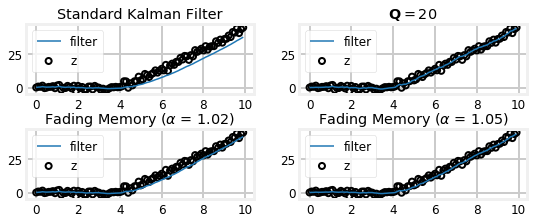

In [23]:
pos2, zs2 = generate_data(70, std=1.2)
xs2 = pos2[:, 0]
z_xs2 = zs2[:, 0]

cvfilter = make_cv_filter(dt, std=1.2)
cvfilter.x.fill(0.)
cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=0.02)
cvfilter.alpha = 1.00

xs, res = [], []
for z in z_xs2:
    cvfilter.predict()
    cvfilter.update([z])
    xs.append(cvfilter.x[0])
    res.append(cvfilter.y[0])
xs = np.asarray(xs)
plt.subplot(221)
bp.plot_measurements(z_xs2, dt=dt, label='z')
plt.plot(t[0:100], xs, label='filter')
plt.legend(loc=2)
plt.title('Standard Kalman Filter')

cvfilter.x.fill(0.)
cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=20.)
cvfilter.alpha = 1.00

xs, res = [], []
for z in z_xs2:
    cvfilter.predict()
    cvfilter.update([z])
    xs.append(cvfilter.x[0])
    res.append(cvfilter.y[0])
    
xs = np.asarray(xs)

plt.subplot(222)
bp.plot_measurements(z_xs2, dt=dt, label='z')
plt.plot(t[0:100], xs, label='filter')
plt.legend(loc=2)
plt.title('$\mathbf{Q}=20$')

cvfilter.x.fill(0.)
cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=0.02)
cvfilter.alpha = 1.02

xs, res = [], []
for z in z_xs2:
    cvfilter.predict()
    cvfilter.update([z])
    xs.append(cvfilter.x[0])
    res.append(cvfilter.y[0])
xs = np.asarray(xs)
plt.subplot(223)
bp.plot_measurements(z_xs2, dt=dt, label='z')
plt.plot(t[0:100], xs, label='filter')
plt.legend(loc=2)
plt.title('Fading Memory ($\\alpha$ = 1.02)')

cvfilter.x.fill(0.)
cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=0.02)
cvfilter.alpha = 1.05

xs, res = [], []
for z in z_xs2:
    cvfilter.predict()
    cvfilter.update([z])
    xs.append(cvfilter.x[0])
    res.append(cvfilter.y[0])
xs = np.asarray(xs)
plt.subplot(224)
bp.plot_measurements(z_xs2, dt=dt, label='z')
plt.plot(t[0:100], xs, label='filter')
plt.legend(loc=2)
plt.title('Fading Memory ($\\alpha$ = 1.05)');

The first plot shows the performance of the Kalman filter. The filter diverges when the maneuver starts and does not reacquire the signal until about 10 seconds. I then made the filter track the maneuver very quickly by making the process noise large, but this has the cost of making the filter estimate very noisy due to unduly weighting the noisy measurements. I then implemented a fading memory filter with $\alpha=1.02$. The filtered estimate is very smooth, but it does take a few seconds to converge when the target regains steady state behavior. However, the time to do so is considerably smaller than for the Kalman filter, and the amount of lag is much smaller - the estimate for the fading memory is much closer to the actual track than the Kalman filter's track is. Finally, I bumped up $\alpha$ to 1.05. Here we can see that the filter responds almost instantly to the maneuver, but that the estimate is not as straight during the steady state operation because the filter is forgetting the past measurements. 

This is quite good performance for such a small change in code! Note that there is no 'correct' choice here. You will need to design your filter based on your needs and the characteristics of the measurement noise, process noise, and maneuvering behavior of the target.

## Multiple Model Estimation

The example I have been using in this chapter entails a target moving in a steady state, performing a maneuver, and then returning to a steady state. We have been thinking of this as two models - a constant velocity model, and a constant acceleration model. Whenever you can describe the system as obeying one of a finite set of models you can use *Multiple Model (MM) Estimation*. We use a bank of multiple filters, each using a different process to describe the system, and either switch between them or blend them based on the dynamics of the tracked object. 

As you might imagine this is a broad topic, and there are many ways of designing and implementing MM estimators. But consider a simple approach for the target we have been tracking in this chapter. One idea would be to simultaneously run a constant velocity and a constant acceleration filter, and to switch between their outputs when we detect a maneuver by inspecting the residuals. Even this choice gives us many options. Consider the dynamics of a turning object. For example, an automobile turns on a wheelbase - the front wheels turn, and the car pivots around the rear wheels. This is a nonlinear process, so for best results we would want to use some type of nonlinear filter (EKF, UKF, etc) to model the turns. On the other hand, a linear constant velocity filter would perform fine for the steady state portions of the travel. So our bank of filters might consist of a linear KF and an EKF filter for the turns. However, neither is particularly well suited for modeling behaviors such as accelerating and braking. So a highly performing MM estimator might contain a bank of many filters, each designed to perform best for a certain performance envelope of the tracked object.

Of course, you do not need to base your filters on the order of the model. You can use different noise models, different adapters in each. For example, in the section above I showed many plots depicting the effects of changing parameters on the estimate of the velocity and position. Perhaps one setting works better for position, and a different setting for velocity. Put both in your bank of filters. You could then take the best estimates for the position from one filter, and the best estimate for the velocity from a different filter.

### A Two Filter Adaptive Filter

I trust the idea of switching between filters to get the best performance is clear, but what mathematical foundations should we use to implement it? The problem that we face is trying to detect via noisy measurements when a change in regime should result in a change in model. What aspect of the Kalman filter measures how far the measurement deviates from the prediction? Yes, the *residual*.

Let's say we have a first order (constant velocity) Kalman filter. As long as the target is not maneuvering the filter will track it's behavior closely, and roughly 68% of the measurements should fall within 1$\sigma$. Furthermore the residual should fluctuate around 0 because as many if the sensor is Gaussian an equal number of measurement should have positive error as have negative errors. If the residual grows and stays beyond predicted bounds then the target must not be performing as predicted by the state model. We saw this earlier in this chart where the residual switched from bouncing around 0 to suddenly jumping and staying above zero once the tracked object began maneuvering.

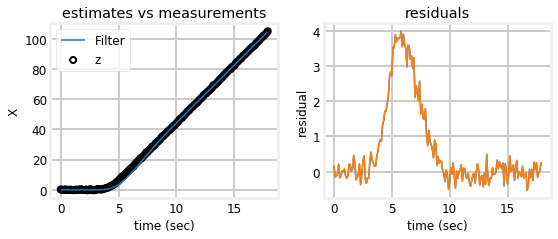

In [24]:
show_residual_chart()

For this problem we saw that the constant velocity filter performed better the constant acceleration filter while the object was in steady state, and the opposite was true when the object is maneuvering. In the chart above that transition occurs at 4 seconds. 

So the algorithm is easy. Initialize both a  constant velocity and constant acceleration filter and run them together in a predict/update loop. After every update examine the residual of the  constant velocity filter. If it falls within theoretical bounds use the estimate from the constant velocity filter as the estimate, otherwise use the estimate from the constant acceleration filter.

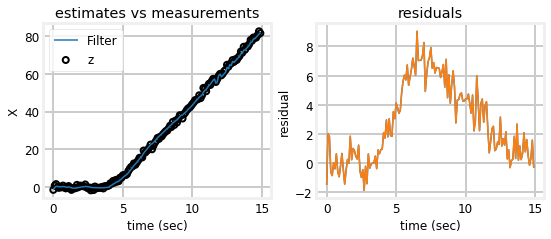

In [25]:
def run_filter_bank(threshold, show_zs=True):
    dt = 0.1
    cvfilter= make_cv_filter(dt, std=0.8)
    cafilter = make_ca_filter(dt, std=0.8)
    pos, zs = generate_data(120, std=0.8)
    z_xs = zs[:, 0]
    xs, res = [], []

    for z in z_xs:
        cvfilter.predict()
        cafilter.predict()
        cvfilter.update([z])
        cafilter.update([z])
        
        std = np.sqrt(cvfilter.R[0,0])
        if abs(cvfilter.y[0]) < 2 * std:
            xs.append(cvfilter.x[0])
        else:
            xs.append(cafilter.x[0])
        res.append(cvfilter.y[0])
    xs = np.asarray(xs)
    if show_zs:
        plot_track_and_residuals(dt, xs, z_xs, res)
    else:
        plot_track_and_residuals(dt, xs, None, res)

run_filter_bank(threshold=1.4)

Here the filter tracks the maneuver closely. While the target is not maneuvering our estimate is nearly noise free, and then once it does maneuver we quickly detect that and switch to the constant acceleration filter. However, it is not ideal. Here is the filter output plotted alone:

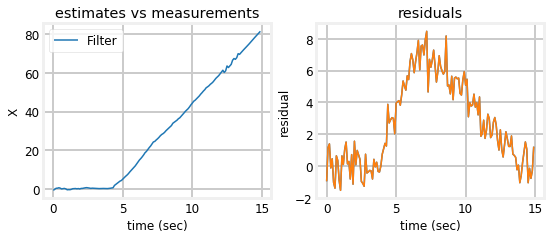

In [26]:
run_filter_bank(threshold=1.4, show_zs=False)

You can see that the estimate jumps when the filter bank switches from one filter to the other. I would not use this algorithm in a production system. The next section gives a state of the art implementation of a filter bank that eliminates this problem.

## MMAE

The core idea of using several filters to detect a maneuver is sound, but the estimate is jagged when we abruptly transition between the filters. Choosing one filter over the other flies in the face of this entire book, which uses probability to determine the *likelihood* of measurements and models. We don't choose *either* the measurement or prediction, depending on which is more likely, we choose a *blend* of the two in proportion to their likelihoods. We should do the same here. This approach is called the *Multiple Model Adaptive Estimator*, or MMAE.

In the **Designing Kalman Filters** chapter we learned the *likelihood function* 

$$\mathcal{L} = \frac{1}{\sqrt{2\pi S}}\exp [-\frac{1}{2}\mathbf{y}^\mathsf{T}\mathbf{S}^{-1}\mathbf{y}]$$

which tells us how likely a filter is to be performing optimally given the inputs. $\mathbf y$ is the residual and $\mathbf S$ is the system uncertainty (covariance in measurement space). This is just a Gaussian of the residual and the system uncertainty. A large residual will give a large uncertainty, and thus low likelihood that the measurement matches the filter's current state. We can use this to compute the probability that each filter is the best fit to the data. If we have N filters, we can compute the probability that filter i is correct in relation to the rest of the filters with

$$p_k^i = \frac{\mathcal{L}_k^ip_{k-1}^i}{\sum\limits_{j=1}^N \mathcal{L}_k^jp_{k-1}^j}$$

That looks messy, but it is straightforward. The numerator is just the likelihood from this time step multiplied by the probability that this filter was correct at the last time frame. We need all of the probabilities for the filter to sum to one, so we normalize by the probabilities for all of the other filters with the term in the denominator. 

That is a recursive definition, so we need to assign some initial probability for each filter. In the absence of better information, use $\frac{1}{N}$ for each. Then we can compute the estimated state as the sum of the state from each filter multiplied the the probability of that filter being correct.

Here is a complete implementation:

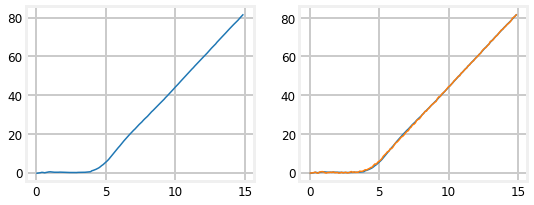

In [27]:
def run_filter_bank():
    dt = 0.1
    cvfilter = make_cv_filter(dt, std=0.2)
    cafilter = make_ca_filter(dt, std=0.2)

    _, zs = generate_data(120, std=0.2)
    z_xs = zs[:, 0]
    xs, probs = [], []

    pv, pa = 0.8, 0.2
    pvsum, pasum = 0., 0.
    
    for z in z_xs:
        cvfilter.predict()
        cafilter.predict()
        cvfilter.update([z])
        cafilter.update([z])
        
        cv_likelihood = cvfilter.likelihood * pv
        ca_likelihood = cafilter.likelihood * pa
        
        pv = (cv_likelihood) / (cv_likelihood + ca_likelihood)
        pa = (ca_likelihood) / (cv_likelihood + ca_likelihood)
        
        x = (pv * cvfilter.x[0]) + (pa*cafilter.x[0])
        xs.append(x)
        probs.append(pv / pa)

    xs = np.asarray(xs)
    t = np.arange(0, len(xs) * dt, dt)
    plt.subplot(121)
    plt.plot(t, xs)
    plt.subplot(122)
    plt.plot(t, xs)
    plt.plot(t, z_xs)
    return xs, probs

xs, probs = run_filter_bank()

I plot the filter's estimates alone on the left so you can see how smooth the result is. On the right I plot both the estimate and the measurements to prove that the filter is tracking the maneuver. 

Again I want to emphasize that this is nothing more than the Bayesian algorithm we have been using throughout the book. We have two (or more) measurements or estimate, each with an associated probability. We choose are estimate as a weighted combination of each of those values, where the weights are proportional to the probability of correctness. The computation of the probability at each step is 

$$\frac{\texttt{Prob(meas | state)} \times\texttt{prior}}{\texttt{normalization}}$$

which is Bayes therom.

For real world problems you are likely to need more than two filters in your bank. In my job I track objects using computer vision. I track hockey pucks. Pucks slide, they bounce and skitter, they roll, they ricochet, they are picked up and carried, and they are 'dribbled' quickly by the players. I track humans who are athletes, and their capacity for nonlinear behavior is nearly limitless. A two filter bank doesn't get very far in those circumstances. I need to model multiple process models, different assumptions for noise due to the computer vision detection, and so on. But you have the main idea. 

### Limitations of the MMAE Filter

The MMAE as I have presented it has a significant problem. Look at this chart of the ratio of the probability for the constant velocity vs constant acceleration filter.

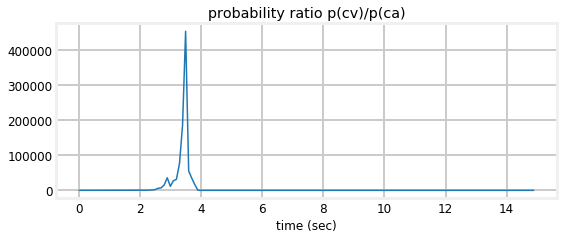

In [28]:
plt.plot(t[0:len(probs)], probs)
plt.title('probability ratio p(cv)/p(ca)')
plt.xlabel('time (sec)');

For the first three seconds, while the tracked object travels in a straight direction, the constant velocity filter become much more probable than the constant acceleration filter. Once the maneuver starts the probability quickly changes to to favor the constant acceleration model. However, the maneuver is completed by second six. You might expect that the probability for the constant velocity filter would once again become large, but instead it remains at zero.

This happens because of the recursive computation of the probability:

$$p_k = \frac{\mathcal{L}p_{k-1}}{\sum \text{probabilities}}$$

Once the probability becomes very small it can never recover. The result is that the filter bank quickly converges on only the most probable filters. A robust scheme needs to monitor the probability of each filter and kill off the filters with very low probability and replace them with filters with greater likelihood of performing well. You can subdivide the existing filters into new filters that try to span the characteristics that make them perform well. In the worst case, if a filter has diverged you can reinitialize a filter's state so that it is closer to the current measurements. 

## Interacting Multiple Models (IMM)

Let's think about multiple models in another way. The scenario is as before - we wish to track a maneuvering target. We can design a set of Kalman filters which make different modeling assumptions. They can differ in terms of the filter order, or in the amount of noise in the process model. As each new measurement comes in each filter has a probability of being the correct model.

This naive approach leads to combinatorial explosion. At step 1 we generate $N$ hypotheses, or 1 per filter. At step 2 we generate another $N$ hypotheses which then need to be combined with the prior $N$ hypotheses, which yields $N^2$ hypothesis. Many different schemes have been tried which either cull unlikely hypotheses or merge similar ones, but the algorithms still suffered from computational expense and/or poor performance. I will not cover these in this book, but prominent examples in the literature are the generalized pseudo Bayes (GPB) algorithms.

The *Interacting Multiple Models* (IMM) algorithm was invented by Blom[5] to solve the combinatorial explosion problem of multiple models. A subsequent paper by Blom and Bar-Shalom is the most cited paper [6]. The idea is to have 1 filter for each possible mode of behavior of the system. At each epoch we we let the filters *interact* with each other. The more likely filters modify the estimates of the less likely filters so they more nearly represent the current state of the sytem. This blending is done probabilistically, so the unlikely filters also modify the likely filters, but by a much smaller amount. 

For example, suppose we have two modes: going straight, or turning. Each mode is represented by a Kalman filter, maybe a first order and second order filter. Now say the target it turning. The second order filter will produce a good estimate, and the first order filter will lag the signal. The likelihood function of each tells us which of the filters is most probable. The first order filter will have low likelihood, so we adjust its estimate greatly with the second order filter. The the second order filter is very likely, so its estimate will only be changed slightly by the first order Kalman filter. 

Now suppose the target stops turning. Because we have been revising the first order filter's estimate with the second order estimate it will not have been lagging the signal by very much. within just a few epochs it will be producing very good (high likelihood) estimates and be the most probable filter. It will then start contributing heavily to the estimate of the second order filter. Recall that a second order filter mistakes measurement noise for acceleration. This adjustment insures reduces this effect greatly.

### Mode Probabilities

We define a set of modes for our system, $m$, and assume that the target is always in one of these modes. In the discussion above we have the modes straight and turn, so $m=\{\text{straight},\ \text{turn}\}$.


We assign a probability that the target is in any given mode. This gives us a vector of *mode probabilities* with one probability for each possible mode. $m$ has two modes, so we will have a vector of two probabilities. If we think that there is a 70% chance that the target is going straight we can say

$$\mu = \begin{bmatrix} 0.7 & 0.3\end{bmatrix}$$

We get 0.3 for the turn because the probabilities must sum to one. $\mu$ is typically but not universally used as the symbol for the mode probabilities, so I will use it. Do not confuse it with the mean.

In Python we can implement this as

In [29]:
mu = np.array([0.7, 0.3])
mu

array([0.7, 0.3])

We can formalize it by saying that the prior probability that $m_i$ is correct (the maneuvering object is in mode $i$), given the prior measurements $Z$, is

$$\mu_i = P(m_i|Z)$$

### Mode Transitions

Next we have to consider that this is a maneuvering target. It will go straight, then turn, then go straight again. We can model the transition between these modes as a [*Markov chain*](https://en.wikipedia.org/wiki/Markov_chain), as in this illustration:

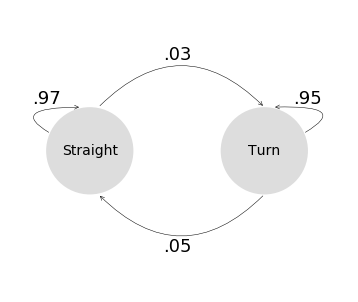

In [30]:
import kf_book.adaptive_internal as adaptive_internal
adaptive_internal.plot_markov_chain()

This shows an example of two modes for a target, going straight and performing a turn. If the current mode of the target is straight, then we predict that there is a 97% chance of the target continuing straight, and a 3% chance of starting a turn. Once the target is turning, we then predict that there is a 95% chance of staying in the turn, and a 5% of returning to a straight path.

The algorithm is not sensitive to the exact numbers, and you will typically use simulation or trials to choose appropriate values. However, these values are quite representative.

We represent Markov chains with a [*transition probability matrix*](https://en.wikipedia.org/wiki/Stochastic_matrix), which we will call $\mathbf M$. For the Markov chain in the illustration we would write

$$\mathbf M = \begin{bmatrix}.97 & .03\\.05 & .95\end{bmatrix}$$

In other words $\mathbf M[i, j]$ is the probability of mode being $i$ given that the last mode was $j$. In this example the probability of the mode currently being straight $(i=0)$ given that the last mode was a turn $(j=1)$ is $\mathbf M[1,\ 0] = 0.05$. In Python we'd write:

In [31]:
M = np.array([[.97, .03], [.05, .95]])
M

array([[0.97, 0.03],
       [0.05, 0.95]])

This allows us to compute the new mode probabilities based on the probability of a transition. Let's compute the probability of the mode being straight after a transition. There are two ways for us to be moving straight. We could have been moving straight, and then continued straight, or we could have been turning, but then went straight. The former probability is calculated with $(0.7\times 0.97)$ and the latter with $(0.3\times 0.05)$. We are multiplying the mode probability with the relevant probability from the Markov Chain. The *total probability* is the sum of the two, or $(0.7)(0.97) + (0.3)(0.05) = 0.694$. 

Recall the [*total probability theorem*](https://en.wikipedia.org/wiki/Law_of_total_probability) from the second chapter. It states that the probability of several distinct events is

$$P(A) = \sum P(A\mid B)\, P(B)$$

Here $P(A\mid B)$ is the transition matrix $\mathbf M$ and $P(B)$ is $\mu$. We are using arrays and matrices, and so we take advantage of the fact that a vector times a matrix computes the sum of products: 

$$\begin{bmatrix}\mu_1 & \mu_2 \end{bmatrix}\begin{bmatrix}m_{11} & m_{12}\\m_{21} & m_{22}\end{bmatrix} = \begin{bmatrix}\mu_1 m_{11} + \mu_2 m_{21} & \mu_1 m_{12} + \mu_2 m_{22}\end{bmatrix}$$

The IMM literature expresses this as

$$\bar c_j = \sum\limits_{i=1}^{N} \mu_i M_{ij}$$

We use NumPy's `dot` function to compute this for us:

In [32]:
cbar = np.dot(mu, M)
cbar

array([0.694, 0.306])

### Computing the Mode Probabilities


We will compute the new mode probabilities using Bayes theorem. Recall that Bayes theorem states

$$\text{posterior} = \frac{\text{prior} \cdot \text{likelihood}}{\text{normalization factor}}$$

Here the prior is the total probability computation we performed in the last section. The Kalman filter computes the *likelihood*, which is the likelihood of the measurements given the current state of the filter. For review the equation is:

$$
\mathcal{L} = \frac{1}{\sqrt{2\pi \mathbf S}}\exp [-\frac{1}{2}\mathbf y^\mathsf T\mathbf S^{-1}\mathbf y]$$

In mathematical notation the updated mode probability is:

$$\mu_i = \| \mathcal{L}_i {\bar c}_{i}\|$$

In words, for each Kalman filter (mode) we compute the mode probability as the probability of the current mode taking the possible transition into account times the likelihood that this is the correct mode. Then we normalize all of the probabilities so they sum to one.

This is trivial to compute in Python. I'll introduce the variable `L` to store the likelihoods. Likelihoods are computed by the `KalmanFilter.update()` step, and in the code snippet below I just hard coded values for `L` since we haven't created the Kalman filters yet:

In [33]:
# L = [kf0.L, kf1.L]  # get likelihoods from Kalman filters
L = [0.000134, 0.0000748] 
mu = cbar * L
mu /= sum(mu) # normalize
mu

array([0.802, 0.198])

Here you can see that the relatively strong likelihood for the straight filter pushed the probability for the straight mode from 70% to 80.2%.

## Mixing Probabilities

At this point we could use the mode transitions to compute the probabilities for all possible choices. If $\mu = \begin{bmatrix} 0.63 & 0.27\end{bmatrix}$, then we can use the transition probability matrix to compute all possible outcomes. In other words, if the current mode is straight $(\mu=0.63)$, we can compute two new probabilities based on whether the target keeps moving straight, or turns. We do the same for the turning mode $(\mu=0.27)$. We will have gone from 2 mode probabilities to 4. At the next step 4 will turn into 8, and so on. It's computationally exact, but infeasible in practice. After only 30 epochs you'd require 8GB of memory to store the mode probabilities in double precision.

We need a better, albeit approximate way. IMMs resolve this by computing *mixing probabilities*. The idea is simple. Let's say the first mode (straight) is currently very likely, and the second mode (turn) is unlikely. Instead of having the Kalman filter for the straight mode compute its state as the weighted average of all of the filters in the filter bank. Filters with high probability of matching the target's mode get weighted more than filters with lower probability. The result is that the information from the probable filters improve the accuracy of the filters that are improbable. This is the crux of the algorithm.

What we need to do is very simple. Each Kalman filter performs the update step, computing a new mean and covariance. But then we compute a new mean and covariance for each filter as a weighted sum of these means and covariances according to *mixing probabilities* which we call $\omega$. Likely filters will be slightly adjusted by the unlikely filters, and the unlikely filters will be strongly adjusted by the likely ones. The literature calls these adjusted means and covariances either the *mixed conditions* or *mixed initial conditions*. I use the notation $\mathbf x^m_j$ for the mixed state, and  $\mathbf P^m_j$ for the mixed covariance. The equations are:

$$\begin{aligned}
\mathbf x^m_j &= \sum_{i=1}^N \omega_{ij} \mathbf x_i \\
\mathbf P^m_j &= \sum_{i=1}^N \omega_{ij}\left[(\mathbf x^i - \mathbf  x^m_i) (\mathbf x^i - \mathbf  x^m_i)^\mathsf T + \mathbf P_i\right]
\end{aligned}$$

Just think of the subscripts as indexes into arrays. Putting it in pseudo-Python we can write this as:

```python
for j in N:
    x0[j] = sum_over_i(w[i,j] * x[i])
    P0[j] = sum_over_i(w[i, j] * (P[i] + np.outer(x[i] - x0[j]))) 
```

Don't let the notation confuse what is a simple idea: incorporate estimates from the probable filters into the estimates of the improbable filters, ensuring all have a good estimate.

How do we compute the mixing probabilities? Think about it, and try to give a reasonable answer before reading on. We have mode probabilities which describe the current probability of each mode, and then transition probabilities describing how likely we are to change modes. How do we compute the new probability?

Bayes theorem, of course! Prior times the likelihood, normalized. The prior is the mode probability, and the likelihood comes from the Markov chain, which we store in the matrix $\mathbf M$. 

$$\boldsymbol\omega_{ij} = \| \mu_i \cdot \mathbf M_{ij}\|$$

We can compute this as follows. I computed the update of $\mu$ and $\bar c$ out of order above (ou must compute $\bar c$ incorporating the transition probability matrix into $\mu$), so I'll need to correct that here:

In [34]:
cbar = np.dot(mu, M) #compute total probability that target is in mode j

omega = np.zeros((2, 2))
for i in range(2):
    for j in range(2):
        omega[i, j] = (M[i, j] * mu[i]) / cbar[j]
omega

array([[0.987, 0.114],
       [0.013, 0.886]])

The Kalman filters need to perform the prediction step to compute the new prior. They use the mixed estimates:

$$
\begin{aligned}
\bar{\mathbf x}_j &= \mathbf F_j\mathbf x^m_j\\
\bar{\mathbf P}_j &= \mathbf F_j\mathbf P^m_j\mathbf F_j^\mathsf T + \mathbf Q_j
\end{aligned}$$

### IMM Estimate

Now we need a final state estimate from the bank of filters. How do we do that? Just weight the mixed estimate from each Kalman filter:

$$\begin{aligned}
\mathbf x &= \sum_{j=1}^N \mu_j{\bar{\mathbf x}}_j\\
\mathbf P &= \sum_{j=1}^N \mu_j\left[(\bar{{\mathbf x}}_j - \bar{\mathbf x})({\bar{\mathbf x}}_j - \bar{\mathbf x})^\mathsf T + \bar{\mathbf P_j}\right]
\end{aligned}$$

### Tracking Maneuvering Target with the IMM

Let's work an example. Crassidis[4] is one of the few texts with a worked example, so I have chosen his example. He tracks a moving target for 600 seconds. The target starts off moving straight, and then a control input is injected starting at 400 seconds, causing the target to make a 90 degree turn. He uses two constant acceleration Kalman filters. One filter assumes no process noise, and the other assumes process noise with spectral density $10^{-3}\mathbf I$. He assumes very good initialization of the filters, setting $\mathbf P =10^{-12}$ for both filters. My implementation follows:

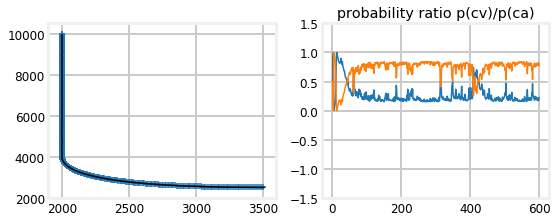

In [35]:
import copy
from filterpy.kalman import IMMEstimator
from scipy.linalg import block_diag

N = 600
dt = 1.
imm_track = adaptive_internal.turning_target(N)

# create noisy measurements
zs = np.zeros((N, 2))
r = 1
for i in range(N):
    zs[i, 0] = imm_track[i, 0] + randn()*r
    zs[i, 1] = imm_track[i, 2] + randn()*r

ca = KalmanFilter(6, 2)
dt2 = (dt**2)/2
F = np.array([[1, dt, dt2],
              [0,  1,  dt],
              [0,  0,   1]])
            
ca.F = block_diag(F, F)
ca.x = np.array([[2000., 0, 0, 10000, -15, 0]]).T
ca.P *= 1.e-12
ca.R *= r**2
q = np.array([[.05, .125, 1/6],
              [.125, 1/3, .5],
              [1/6, .5, 1]])*1.e-3
ca.Q = block_diag(q, q)
ca.H = np.array([[1, 0, 0, 0, 0, 0],
                 [0, 0, 0, 1, 0, 0]])

# create identical filter, but with no process error
cano = copy.deepcopy(ca)
cano.Q *= 0

filters = [ca, cano]

M = np.array([[0.97, 0.03],
              [0.03, 0.97]])
mu = np.array([0.5, 0.5])
bank = IMMEstimator(filters, mu, M)

xs, probs = [], []
cvxs, caxs = [], []
for i, z in enumerate(zs):
    z = np.array([z]).T
    bank.update(z)

    xs.append(bank.x.copy())
    cvxs.append(ca.x.copy())
    caxs.append(cano.x.copy())
    probs.append(bank.mu.copy())

xs = np.array(xs)
cvxs = np.array(cvxs)
caxs = np.array(caxs)
probs = np.array(probs)
plt.subplot(121)
plt.plot(xs[:, 0], xs[:, 3], 'k')
plt.scatter(zs[:, 0], zs[:, 1], marker='+')

plt.subplot(122)
plt.plot(probs[:, 0])
plt.plot(probs[:, 1])
plt.ylim(-1.5, 1.5)
plt.title('probability ratio p(cv)/p(ca)');

It is rather hard to see the performance of the filter, so let's look at the performance just as the turn starts. I've swapped the $x$ and $y$ axis to let us zoom in closely. In the chart below the turn starts at $Y=4000$. If you look very closely you can see that the estimate wavers slightly after the turn is initiated, but the filter tracks the measurement without lag and soon tracks smoothly.

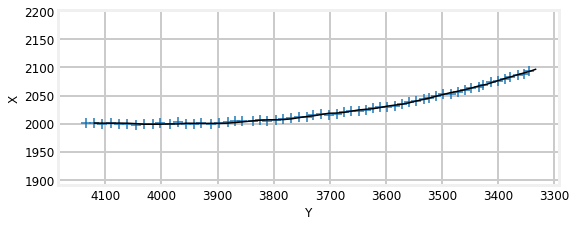

In [36]:
plt.plot(xs[390:450, 3], xs[390:450, 0], 'k')
plt.scatter(zs[390:450, 1], zs[390:450, 0], marker='+', s=100);
plt.xlabel('Y'); plt.ylabel('X')
plt.gca().invert_xaxis()
plt.axis('equal');

### Limitations of the IMM

I haven't extensively worked with the IMM, so I am unable to address this as well as I would like. However, the IMM was invented to track maneuvering aircraft for air traffic control, and by all reports it performs superbly in that role. 

That use case assumes a few things. Foremost among them is the requirement that all of the filters in the bank have the same dimensional design. A review of the math should show why. To create the mixed estimate the IMM performs this computation:

$$\mathbf x = \sum_{j=1}^N \mu_j{\bar{\mathbf x}}_j$$

This is computable if and only if the state $x$ in each filter is of the same dimension. Furthermore, the interpretation of $x[i]$ must be the same for each filter. 

For example, suppose we tried to filter that uses a constant velocity model and another with a constant acceleration model. This doesn't work because the dimension of $x$ are different. `FilterPy` will raise a `ValueError` if you try to use filters with different dimensions.

In [38]:
ca = KalmanFilter(3, 1)
cv = KalmanFilter(2, 1)

trans = np.array([[0.97, 0.03],
                  [0.03, 0.97]])

imm = IMMEstimator([ca, cv], (0.5, 0.5), trans)

ValueError: All filters must have the same state dimension

I occasionally get emails or bug reports about this. In the past I have recommended designing the filter with constant velocity to be of dimension 3, and then implement `F` to ignore acceleration

```python
F = np.array([[1, dt, 0],
              [0, 1,  0],
              [0, 0,  0]])
```

In retrospect I am not sure if this is a sound recommendation. It allows the IMM to work, but clearly the estimate for acceleration will be incorrect, since one filter will have an accurate estimate of acceleration, and the other filter will have an estimate of 0. This inaccurate acceleration will then be used to perform the next predict cycle. 

Consider a more extreme case. Suppose one of your filters interprets `x[2]` to be acceleration, and another filter interprets it as angular rotation rate. Clearly `x[2]` of the mixed estimate will be meaningless since you cannot sum (linear) acceleration with a rotation rate.

As I said I am not particularly well versed in the IMM. Perhaps the literature explains how to handle these situations. All I can say is that the IMM implemented by FilterPy will not work for these use cases.

The IMM as designed for air traffic control uses filters with different process assumptions. An aircraft can be flying level, it can be descending/ascending, it can be performing a coordinated turn, or an uncoordinated turn. You can design a filter for each case with a different `F` and `Q` matrix, but the state estimate `x` will be the same for all. 

## Summary

This chapter contains some of the more challenging material in this book. However, it is the gateway to implementing realistic Kalman filters. If we are controlling a robot we know its process model, and it is easy to construct a Kalman filter for it. Far more commonly we are given a set of time series data and asked to make sense of it. The process model is largely unknown to us. We use the techniques in this chapter to *learn* (in a machine learning sense) how to parameterize our models. The models change over time as the target maneuver, so our filters must be adaptive. 

Finding an optimal answer involves combinatorial explosion, and is impractical in practice. The IMM algorithm has become the standard algorithm because of its good performance and computational tractability.

A real filter bank usually involves more than two filters. It is common to have many filters. As the target's regime changes some filters become infinitesimally likely. Most adaptive filters implement an algorithm that kills off extremely unlikely filters and replaces them with filters that more closely match the current regime. This is highly specific to your problem space, and is usually very ad-hoc. You will need to devise schemes for killing and creating filters and test them against simulated or real data. 

Despite the complexity of the algorithms, I hope you recognize the underlying ideas are very simple. We use the same two tools that we learned in the second chapter: Bayes theorem and the total probability theorem. We incorporate new information using Bayes theorem, and compute the effect of the process models using the total probability theorem.

For me, this chapter underscores the beauty of the Bayesian formulation of Kalman filters. I don't much care if you learn the details of the IMM algorithm. I do hope that you see that very simple probabilistic reasoning led to these results. The linear algebra equations of the Kalman filter that Dr. Kalman derived came from a different form of reasoning called *orthogonal projection*. It is beautiful in its own way, and I urge you to read his paper. But I'm not sure I find them intuitive to use, and it is not at all clear how to devise new, non-optimal filters such as the IMM using those techniques. In contrast, Bayes theorem lets us handle these problems with ease. 

## References

 * [1] Bar-Shalom, Y., Xiao-Rong L., and Thiagalingam Kirubarajan. *Estimation with Applications to Tracking and Navigation*. New York: Wiley, p. 424, 2001. 


* [2] Zarchan, P., and Musoff, H., *Fundamentals of Kalman Filtering: A Practical Approach*. Reston, VA: American Institute of Aeronautics and Astronautics, 2000. Print.


* [3] Simon, D., *Optimal State Estimation: Kalman, H and Nonlinear Approaches*. Hoboken, NJ: Wiley-Interscience, p. 208-212, 2006


* [4] Crassidis, John L., and John L. Junkins. *Optimal estimation of dynamic systems*. CRC press, 2011.


* [5] Blom, H.A.P., "An Efficient Filter for Abruptly Changing Systems", *Proceedings of 23rd Conference on Decision and Control*, Las Vegas, NV, Dec 1984.


* [6] Blom, H.A.P and Bar-Shalom, Y., "The Interacting Multiple Model Algorithm for Systems with Markovian Switching Coefficients", *IEEE Transactions on Automatic Control*, Vol. AC-8, No. 8, Aug. 1998, pp. 780-783.